<center><h1>YOLO Object Detector for Whale & Dolphin Images - Inference</h1></center>

# Introduction

🐠 This one is set up simply to take a given folder, and run an already trained model to infer the bounding boxes.

Was run on Colab.  Not tested on my local machine.

Some useful references:

[Great-Barrier-Reef: YOLOv5 [infer] 🌊](https://www.kaggle.com/awsaf49/great-barrier-reef-yolov5-infer)

[official YOLOv5 user notebook on Kaggle by Ultralytics](https://www.kaggle.com/ultralytics/yolov5). Full tutorial on how to get started. 

[And this one putting them together by Andrada Oleanu](https://www.kaggle.com/andradaolteanu/greatbarrierreef-yolo-full-guide-train-infer)

[And this one also handy](https://blog.paperspace.com/train-yolov5-custom-data/)

### ⬇ Libraries and Dependencies Below

## YOLOv5 Setup

To use the model we need to have the following:
* Yolov5 Repository ([available in this dataset by Awsaf](https://www.kaggle.com/awsaf49/yolov5-lib-ds))
* Python 3
* PyTorch
* CUDA

In [ ]:
# Standard Libraries
import os
import sys
import time
import random
import shutil
import yaml
from tqdm import tqdm
import warnings
import cv2
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from IPython.display import display_html
import PIL.Image
from pathlib import Path

In [ ]:
#Check for the environment
IN_COLAB = 'google.colab' in sys.modules  #Checking if this is running in Colab
IN_KAGGLE = os.environ.get('PWD') == '/kaggle/working'

if (IN_COLAB):
  root = Path(os.getcwd())
  project_folder = root / 'drive/My Drive/Colab Notebooks/Kaggle/Happy_Whale'
  ##########################Change as required#############################
  #image_folder = project_folder / 'yolo_data/infer_images/all_train_images_768'
  image_folder = project_folder / 'yolo_data/infer_images/all_test_images_768'
  #image_folder = project_folder / 'yolo_data/images/test'
  #########################################################################     
  print("Running on Colab")
  print('The project folder is:', project_folder)
  print('The image folder is:', image_folder)

#   if IN_KAGGLE:
#    print("We are running on a Kaggle Server")

#   if not IN_COLAB or IN_KAGGLE:   
#    IN_OTHER = True
#    print("Running on a machine with personalised directory structures")

Running on Colab
The project folder is: /content/drive/My Drive/Colab Notebooks/Kaggle/Happy_Whale
The image folder is: /content/drive/My Drive/Colab Notebooks/Kaggle/Happy_Whale/yolo_data/infer_images/all_test_images_768


In [ ]:
# Custom colors     color class used here is ANSI escape code coloring, for coloring in terminal windows.  
class color:
    S = '\033[1m' + '\033[94m'
    E = '\033[0m'

In [ ]:
if IN_COLAB:
  from google.colab import drive
  pro_dir = Path('drive/My Drive/Colab Notebooks/') / project_folder
  if not os.path.isdir(project_folder):    # Just checking if mounted already
    drive.mount('/content/drive')   

# if IN_OTHER:
#   PRO_DIR = Path(os.path.realpath('__file__')) # For working on a local machine 

print('Initial Working directory: ', os.getcwd()) # Reference subdirectories  project_folder / <MY_DIR_NAME>
os.chdir(project_folder / 'yolov5')
print("Current working directory: {0}".format(os.getcwd()))

Initial Working directory:  /content
Current working directory: /content/drive/My Drive/Colab Notebooks/Kaggle/Happy_Whale/yolov5


In [ ]:
# install YOLO dependencies as necessary

#%pip install -qr requirements.txt 
import torch
from IPython.display import Image, clear_output  # to display images

print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.10.0+cu111 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


# Set up File Structure for Colab.

The default working directory in Colab is `/content`. But this is a pain because the data gets lost at the end of the session.  So I'm trying to work from a project directory within g-drive, and include the yolov5 repo in there. So in this case `/content/drive/My Drive/Colab Notebooks/Kaggle/Happy_Whale/` 


🐠 The images for inferance to go here: `/content/drive/MyDrive/Colab Notebooks/Kaggle/Happy_Whale/yolo_data/infer_images` 

## II. The Labels

The model output is in YOLO 1.1 format, to use with openCV and pillow we need to convert back to COCO.

For COCO to YOLO, we need to go from `[xmin, ymin, w, h]` to the corresponding yolo format `[xmid, ymid, w, h]`.

<center><img src="https://i0.wp.com/prabhjotkaurgosal.com/wp-content/uploads/2021/03/image.png?resize=1536%2C419&ssl=1" width=900></center>

*Source: [here](https://prabhjotkaurgosal.com/weekly-learnings/weekly-learning-blogs/)*

## The Data

* `infer_data_1`: The competition dataset of 27,000 samples
* `infer_data_2`: The competition test dataset, 28,000 samples

In [ ]:
print(color.S+"Current Working Directory"+color.E, os.getcwd())

Current Working Directory /content/drive/My Drive/Colab Notebooks/Kaggle/Happy_Whale/yolov5


In [ ]:
os.chdir(project_folder)
print(color.S+"Current Working Directory"+color.E, os.getcwd())

Current Working Directory /content/drive/My Drive/Colab Notebooks/Kaggle/Happy_Whale


In [ ]:
# Model
model = torch.hub.load('ultralytics/yolov5', 'custom', 
                       'yolov5/HappyWhale/yolov5m_size512_epochs50_batch32_simple/weights/best.pt')  
                        # custom trained model
images = os.listdir(image_folder) # Make a list of paths

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-4-13 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 290 layers, 20852934 parameters, 0 gradients
Adding AutoShape... 


In [ ]:
csv_name = image_folder.name + '.csv'
csv_path = image_folder.parent / csv_name

with open(csv_path, 'w+', encoding='UTF8') as f:
  writer = csv.writer(f)
  first_line = ['filename', 'xmin', 'ymin', 'xmax', 'ymax', 'confidence']
  writer.writerow(first_line)

  counter = 0
  for img in images:
    # Inference
    image = image_folder / img
    results = model(image, size=512)
    w, h = PIL.Image.open(image).size
    # Results
    #results.print()  # or .show(), .save(), .crop(), .pandas(), etc.
    results.xyxy[0]  # im predictions (tensor)
    df = results.pandas().xyxy[0]  # im predictions (pandas)
    result_list = [img,
                  df['xmin'].min()/w,
                  df['ymin'].min()/h, 
                  df['xmax'].max()/w,
                  df['ymax'].max()/h,
                  df['confidence'].min()]
    writer.writerow(result_list)
    counter +=1
    if counter % 2000 == 0:
      print(counter, 'Files processed')
    #print(result_list)

#fileObject = csv.reader(object.csv_path)
#row_count = sum(1 for row in fileObject)
#print(row_count, 'rows in the saved CSV file')

2000 Files processed
4000 Files processed
6000 Files processed
8000 Files processed
10000 Files processed
12000 Files processed
14000 Files processed
16000 Files processed
18000 Files processed
20000 Files processed
22000 Files processed
24000 Files processed
26000 Files processed


# Plot some predictions

              filename      xmin      ymin      xmax      ymax  confidence
6   7f44855d3d735b.jpg  0.027282  0.069622  0.978516  0.921687    0.891641
7   eed48acd7dfb18.jpg  0.002166  0.601599  0.509223  0.999159    0.693302
8   7a1e2fb59ee392.jpg  0.120061  0.290176  0.859094  0.848635    0.958866
9   d0f059a5a75129.jpg  0.009095  0.090141  0.992396  0.863792    0.526212
10  962e7745071bff.jpg  0.259146  0.308623  0.599664  0.507961    0.956368
11  a63a32ccb32b77.jpg  0.334692  0.406920  0.594932  0.545414    0.951725


ValueError: ignored

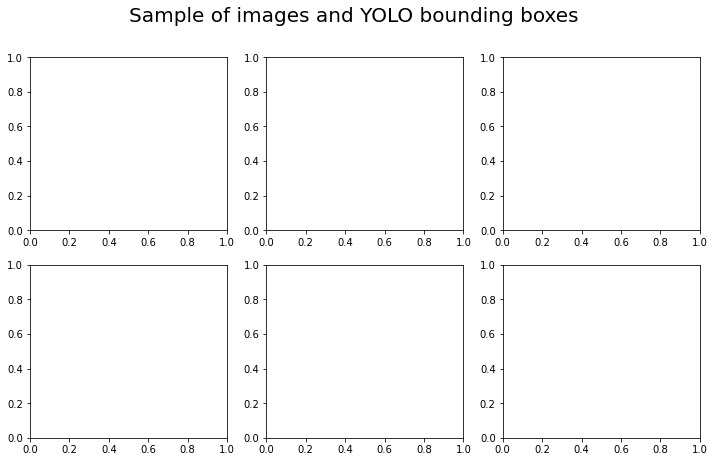

In [ ]:
%matplotlib inline
# Retrieve a sample of data
images = os.listdir(image_folder)[6:12]
# Plot
fig, axs = plt.subplots(2, 3, figsize=(12, 7))
axs = axs.flatten()
fig.suptitle(f"Sample of images and YOLO bounding boxes", fontsize = 20)

df = pd.read_csv (csv_path)
print(df[6:12])

for k in range(6):
    
    # Get the data
    im = cv2.imread(image_folder / images[k])
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    dh, dw, _ = im.shape

     # Draw boxes
     
    #x = df.loc[df['filename'] == images[k]]['x']
        
    # from YOLO to COCO
    #x, y, w, h = box
    #x, y, w, h = float(x), float(y), float(w), float(h)

    l = df.loc[df['filename'] == images[k]]['xmin']*dw #int((x - w / 2) * dw)
    r = df.loc[df['filename'] == images[k]]['xmax']*dh #int((x + w / 2) * dw)
    t = df.loc[df['filename'] == images[k]]['ymax']*dh #int((y - h / 2) * dh)
    b = df.loc[df['filename'] == images[k]]['ymin']*dw #int((y + h / 2) * dh)

    l=0 if np.isnan(l)  else l
    l=dw if np.isnan(r) else r
    l=dh if np.isnan(t) else t
    l=0  if np.isnan(b) else b

    #if l < 0: l = 0
    #if r > dw - 1: r = dw - 1
    #if t < 0: t = 0
    #if b > dh - 1: b = dh - 1

    cv2.rectangle(im, (l, t), (r, b), (255,0,0), 3)
    
    # Show image with bboxes
    axs[k].set_title(images[k], fontsize = 14)
    axs[k].imshow(im)
    axs[k].set_axis_off()

plt.tight_layout()
plt.show()